# Modelling Demand Elasticity

This example demonstrates how demand elasticity can be modelled in PyPSA, using single node capacity expansion model in the style of [model.energy](https://model.energy).

:::{note}
See [this paper by Brown, Neumann, Riepin (2024)](https://arxiv.org/abs/2407.21409) for more details.
:::

## Preparations

Loading packages, example networks and creating a utility function to retrieve price duration curve.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pypsa

plt.style.use("bmh")

In [2]:
def get_price_duration(n: pypsa.Network, bus: str = "electricity") -> pd.Series:
    s = (
        n.buses_t.marginal_price[bus]
        .sort_values(ascending=False)
        .reset_index(drop=True)
    )
    s.index = np.arange(0, 100, 100 / len(s.index))
    return s

In [3]:
# n = pypsa.examples.model_energy()
n = pypsa.Network("../model-energy/model-energy.nc")
n.remove("Load", "demand")
n.remove("Generator", "load shedding")

INFO:pypsa.io:Imported network model-energy.nc has buses, carriers, generators, links, loads, storage_units, stores


## Perfectly inelastic demand

Most commonly, capacity expansion models would prescribe a perfectly inelastic demand via the `p_set` attribute, e.g. 100 MW.

The utility drawn from this consumption is effectively infinite. The model has to find a way to satisfy it. Otherwise, the model is infeasible.

In [4]:
n.add("Load", "demand", bus="electricity", p_set=100)

Index(['demand'], dtype='object')

In [5]:
n.optimize()

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 272.94it/s]
INFO:linopy.io: Writing time: 0.32s


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-d59_m7v7 has 58406 rows; 26286 cols; 115384 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
Presolving model
33618 rows, 24864 cols, 89174 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30698 rows, 21944 cols, 83334 nonzeros  0s
Presolve : Reductions: rows 30698(-27708); columns 21944(-4342); elements 83334(-32050)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(225000) 0s
      17076     8.0834366436e+07 Pr: 5906(1.98633e+07); Du: 0(1.09599e-07) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26286 primals, 58406 duals
Objective: 1.02e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


      21534     1.0174121738e+08 Pr: 0(0); Du: 0(2.00278e-11) 8s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-d59_m7v7
Model status        : Optimal
Simplex   iterations: 21534
Objective value     :  1.0174121738e+08
Relative P-D gap    :  9.0806068359e-15
HiGHS run time      :          7.57
Writing the solution to /tmp/linopy-solve-v6qx_jns.sol


('ok', 'optimal')

Market clearing prices can spike to extreme values in few hours of the year, while remaining close to zero for a majority of time.

<Axes: xlabel='Fraction of Time [%]', ylabel='Clearing Price [€/MWh]'>

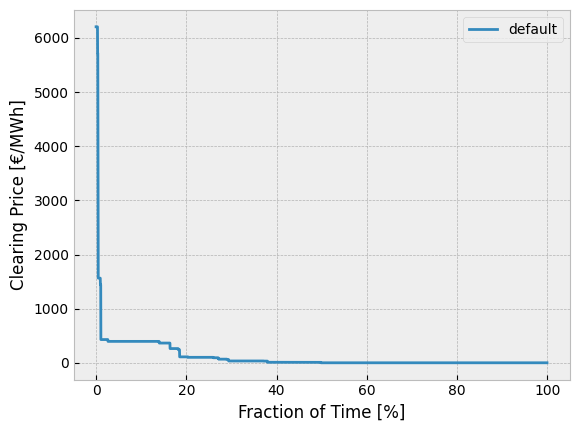

In [6]:
fig, ax = plt.subplots()
get_price_duration(n).plot(ax=ax, ylabel="Clearing Price [€/MWh]", xlabel="Fraction of Time [%]", label="default", legend=True)

In [7]:
capacities = n.statistics.optimal_capacity(round=2).to_frame("inelastic")
capacities

inelastic
component   carrier                    
Link        electrolysis          29.87
            turbine              114.70
Store       hydrogen storage   43276.43
StorageUnit battery storage      284.62
Generator   solar                465.83
            wind                 338.27

## Perfectly inelastic demand up to VOLL

One way to avoid the price spikes is to model demand as perfectly inelastic up to a pre-defined value of lost load (VOLL).

Effectively, this is defined by a utility function $U(d) = Vd$ with a constant value $V$ for consumption $d\in[0,D]$, for instance 2000 €/MWh.

The demand curve is a step function. It is perfectly inelastic up to a price of $V$ at which point it is perfectly elastic.

When we make the substitution $d=D-g$, we see that we can model the VOLL case with a load shedding generator with marginal costs of $V=2000$ €/MWh, omitting the constant term $VD$.

$U(d) = Vd$

$U(d) = VD - Vg$

:::{note}
Note that the objective sense of PyPSA is to minimise costs in order to maximise utility, so any costs have a postive sign and utility gains have a negative sign in the objective
:::

In [8]:
n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost=2000,
    p_nom=100,
)

Index(['load-shedding'], dtype='object')

In [9]:
n.optimize()

Index(['load-shedding'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 291.28it/s]
INFO:linopy.io: Writing time: 0.29s


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-_jddf73c has 64246 rows; 29206 cols; 124144 nonzeros
Coefficient ranges:
  Matrix [2e-04, 3e+00]
  Cost   [1e+02, 2e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 1e+02]
Presolving model
33618 rows, 27784 cols, 92094 nonzeros  0s
Dependent equations search running on 8760 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
30698 rows, 24864 cols, 86254 nonzeros  0s
Presolve : Reductions: rows 30698(-33548); columns 24864(-4342); elements 86254(-37890)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(225500) 0s
      15347     9.1684315652e+07 Pr: 12365(2.54058e+07); Du: 0(5.96435e-09) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64246 duals
Objective: 1.01e+08
Solver model: available
Solver message: optimal



      18475     1.0131084982e+08 Pr: 0(0); Du: 0(2.18198e-11) 7s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-_jddf73c
Model status        : Optimal
Simplex   iterations: 18475
Objective value     :  1.0131084982e+08
Relative P-D gap    :  7.3541783629e-16
HiGHS run time      :          7.47
Writing the solution to /tmp/linopy-solve-px9g2kzm.sol


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

Now, the peak price is capped at 2000 €/MWh:

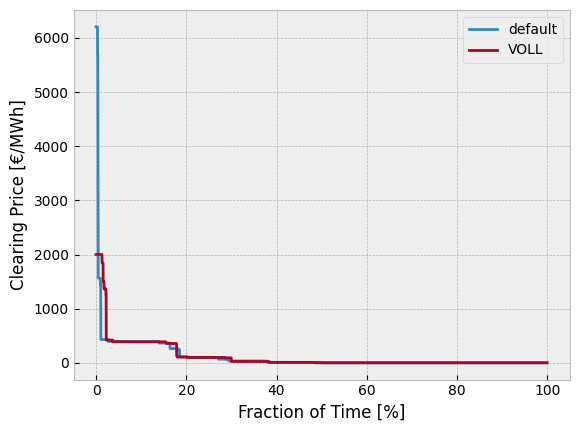

In [10]:
get_price_duration(n).plot(ax=ax, label="VOLL", legend=True)
fig

This results in some changes in the cost-optimal capacity mix, in particular in terms of backup capacities.

In [11]:
capacities["VOLL"] = n.statistics.optimal_capacity(round=2)
capacities

inelastic      VOLL
component   carrier                              
Link        electrolysis          29.87     28.29
            turbine              114.70    103.15
Store       hydrogen storage   43276.43  39706.93
StorageUnit battery storage      284.62    273.75
Generator   solar                465.83    430.89
            wind                 338.27    369.38

## Linear demand curve

In reality, electricity demand is at least partially elastic. Consumers would use less electricity if its more expensive, or would use more electricity if prices are low. 

For a linear demand curve $p = a - bd$, where $p$ is the price, the utility is quadratic: $U(d) = ad - 0.5 b d^2$

For a choice of $a=2000$ and $b=20$, the demand curve looks like this:

Text(0, 0.5, 'Price (€/MWh)')

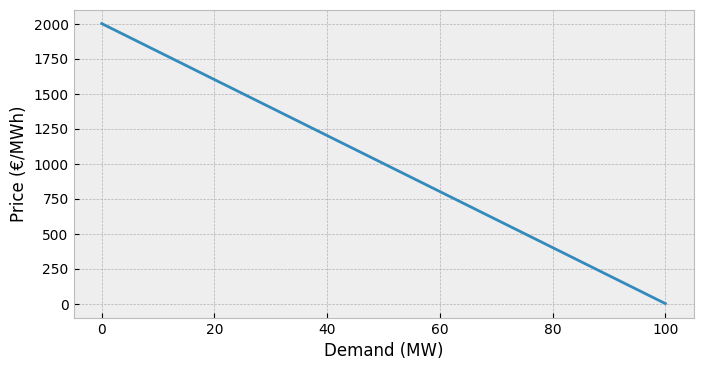

In [12]:
x = np.linspace(0, 100, 200)
plt.figure(figsize=(8, 4))
plt.plot(x, 2000 - 20*x)
plt.xlabel('Demand (MW)')
plt.ylabel('Price (€/MWh)')

That means, for instance, at a price of 1000 €/MWh, the demand would be only 50 MW. At a price of 400 €/MWh, 80 MW. And so on.

Applying the same substition $d = a/b - g$ ($a/b$ yields the maximum consumption at the zero point), turns 

$U(d) = ad - 0.5 b d^2$

into 

$U(g) = \frac{a^2}{2b} - 0.5 b g^2$

which represents a load shedding generator with quadratic marginal cost $b/2$, again omitting the constant term from the objective.

Due to the quadratic terms in the objective function, this addition turns the model into a quadratic problem (QP).

In [13]:
n.remove("Generator", "load-shedding")

n.add(
    "Generator",
    "load-shedding",
    bus="electricity",
    carrier="load",
    marginal_cost_quadratic=20 / 2,
    p_nom=100,
)

Index(['load-shedding'], dtype='object')

In [14]:
n.optimize(solver_name="gurobi")

Index(['load-shedding'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 261.56it/s]
INFO:linopy.io: Writing time: 0.33s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


Read LP format model from file /tmp/linopy-problem-hhv8a0xl.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-hhv8a0xl.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 64246 rows, 29206 columns, 124144 nonzeros


INFO:gurobipy:obj: 64246 rows, 29206 columns, 124144 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.10")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.10")


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 64246 rows, 29206 columns and 124144 nonzeros


INFO:gurobipy:Optimize a model with 64246 rows, 29206 columns and 124144 nonzeros


Model fingerprint: 0x50cd7545


INFO:gurobipy:Model fingerprint: 0x50cd7545


Model has 2920 quadratic objective terms


INFO:gurobipy:Model has 2920 quadratic objective terms


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-04, 3e+00]


INFO:gurobipy:  Matrix range     [2e-04, 3e+00]


  Objective range  [1e+02, 2e+05]


INFO:gurobipy:  Objective range  [1e+02, 2e+05]


  QObjective range [6e+01, 6e+01]


INFO:gurobipy:  QObjective range [6e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 33548 rows and 4342 columns


INFO:gurobipy:Presolve removed 33548 rows and 4342 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 30698 rows, 24864 columns, 86254 nonzeros


INFO:gurobipy:Presolved: 30698 rows, 24864 columns, 86254 nonzeros


Presolved model has 2920 quadratic objective terms


INFO:gurobipy:Presolved model has 2920 quadratic objective terms


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 7.308e+04


INFO:gurobipy: AA' NZ     : 7.308e+04


 Factor NZ  : 4.839e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 4.839e+05 (roughly 26 MB of memory)


 Factor Ops : 7.913e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.913e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.46066356e+12 -1.53313596e+12  1.85e+03 9.38e+02  1.00e+06     0s


INFO:gurobipy:   0   1.46066356e+12 -1.53313596e+12  1.85e+03 9.38e+02  1.00e+06     0s


   1   5.34676241e+10 -1.72471623e+11  4.72e+02 2.53e+02  3.52e+05     0s


INFO:gurobipy:   1   5.34676241e+10 -1.72471623e+11  4.72e+02 2.53e+02  3.52e+05     0s


   2   9.91450308e+09 -9.32488249e+10  2.75e+01 1.42e+01  2.32e+04     0s


INFO:gurobipy:   2   9.91450308e+09 -9.32488249e+10  2.75e+01 1.42e+01  2.32e+04     0s


   3   8.12329203e+09 -2.68103236e+10  2.81e-01 1.42e-01  8.84e+02     0s


INFO:gurobipy:   3   8.12329203e+09 -2.68103236e+10  2.81e-01 1.42e-01  8.84e+02     0s


   4   3.58184390e+09 -4.68844349e+09  4.60e-02 2.33e-02  1.92e+02     0s


INFO:gurobipy:   4   3.58184390e+09 -4.68844349e+09  4.60e-02 2.33e-02  1.92e+02     0s


   5   1.81622987e+09 -1.67384582e+09  1.53e-02 7.98e-03  7.70e+01     0s


INFO:gurobipy:   5   1.81622987e+09 -1.67384582e+09  1.53e-02 7.98e-03  7.70e+01     0s


   6   8.27411021e+08 -5.23903940e+08  4.26e-03 2.16e-03  2.85e+01     0s


INFO:gurobipy:   6   8.27411021e+08 -5.23903940e+08  4.26e-03 2.16e-03  2.85e+01     0s


   7   3.89837647e+08 -1.75480812e+08  1.54e-03 7.96e-04  1.16e+01     0s


INFO:gurobipy:   7   3.89837647e+08 -1.75480812e+08  1.54e-03 7.96e-04  1.16e+01     0s


   8   1.99689379e+08 -4.55261315e+07  5.58e-04 2.92e-04  4.99e+00     0s


INFO:gurobipy:   8   1.99689379e+08 -4.55261315e+07  5.58e-04 2.92e-04  4.99e+00     0s


   9   1.38691203e+08  1.64644246e+07  1.82e-04 9.22e-05  2.46e+00     0s


INFO:gurobipy:   9   1.38691203e+08  1.64644246e+07  1.82e-04 9.22e-05  2.46e+00     0s


  10   1.26260545e+08  3.15735446e+07  1.27e-04 6.42e-05  1.90e+00     0s


INFO:gurobipy:  10   1.26260545e+08  3.15735446e+07  1.27e-04 6.42e-05  1.90e+00     0s


  11   1.15678196e+08  5.16836230e+07  6.15e-05 3.11e-05  1.28e+00     0s


INFO:gurobipy:  11   1.15678196e+08  5.16836230e+07  6.15e-05 3.11e-05  1.28e+00     0s


  12   9.59927167e+07  7.26615877e+07  1.27e-05 6.43e-06  4.61e-01     0s


INFO:gurobipy:  12   9.59927167e+07  7.26615877e+07  1.27e-05 6.43e-06  4.61e-01     0s


  13   8.84908528e+07  8.11620247e+07  1.35e-06 6.84e-07  1.44e-01     0s


INFO:gurobipy:  13   8.84908528e+07  8.11620247e+07  1.35e-06 6.84e-07  1.44e-01     0s


  14   8.78093705e+07  8.23645986e+07  9.96e-07 5.04e-07  1.07e-01     0s


INFO:gurobipy:  14   8.78093705e+07  8.23645986e+07  9.96e-07 5.04e-07  1.07e-01     0s


  15   8.71783797e+07  8.36051674e+07  4.35e-07 2.20e-07  7.02e-02     0s


INFO:gurobipy:  15   8.71783797e+07  8.36051674e+07  4.35e-07 2.20e-07  7.02e-02     0s


  16   8.65112354e+07  8.52321910e+07  7.51e-08 3.80e-08  2.51e-02     0s


INFO:gurobipy:  16   8.65112354e+07  8.52321910e+07  7.51e-08 3.80e-08  2.51e-02     0s


  17   8.62922769e+07  8.58089132e+07  3.27e-09 1.65e-09  9.49e-03     0s


INFO:gurobipy:  17   8.62922769e+07  8.58089132e+07  3.27e-09 1.65e-09  9.49e-03     0s


  18   8.62119690e+07  8.60915159e+07  4.06e-09 6.25e-13  2.37e-03     0s


INFO:gurobipy:  18   8.62119690e+07  8.60915159e+07  4.06e-09 6.25e-13  2.37e-03     0s


  19   8.61915352e+07  8.61728779e+07  4.89e-10 1.42e-13  3.66e-04     0s


INFO:gurobipy:  19   8.61915352e+07  8.61728779e+07  4.89e-10 1.42e-13  3.66e-04     0s


  20   8.61881637e+07  8.61854664e+07  5.04e-10 1.14e-12  5.30e-05     0s


INFO:gurobipy:  20   8.61881637e+07  8.61854664e+07  5.04e-10 1.14e-12  5.30e-05     0s


  21   8.61876334e+07  8.61874723e+07  2.94e-10 1.93e-12  3.16e-06     0s


INFO:gurobipy:  21   8.61876334e+07  8.61874723e+07  2.94e-10 1.93e-12  3.16e-06     0s


  22   8.61875961e+07  8.61875918e+07  1.64e-09 9.09e-13  8.28e-08     0s


INFO:gurobipy:  22   8.61875961e+07  8.61875918e+07  1.64e-09 9.09e-13  8.28e-08     0s


  23   8.61875950e+07  8.61875929e+07  2.38e-07 1.66e-12  3.98e-08     1s


INFO:gurobipy:  23   8.61875950e+07  8.61875929e+07  2.38e-07 1.66e-12  3.98e-08     1s


  24   8.61875949e+07  8.61875930e+07  1.08e-07 9.27e-13  3.59e-08     1s


INFO:gurobipy:  24   8.61875949e+07  8.61875930e+07  1.08e-07 9.27e-13  3.59e-08     1s


  25   8.61875941e+07  8.61875939e+07  2.43e-07 3.88e-12  5.22e-09     1s


INFO:gurobipy:  25   8.61875941e+07  8.61875939e+07  2.43e-07 3.88e-12  5.22e-09     1s


INFO:gurobipy:


Barrier solved model in 25 iterations and 0.56 seconds (0.47 work units)


INFO:gurobipy:Barrier solved model in 25 iterations and 0.56 seconds (0.47 work units)


Optimal objective 8.61875941e+07


INFO:gurobipy:Optimal objective 8.61875941e+07


INFO:gurobipy:
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64246 duals
Objective: 8.62e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

The price duration curve is considerably smoother with less extreme prices and fewer zero-price hours:

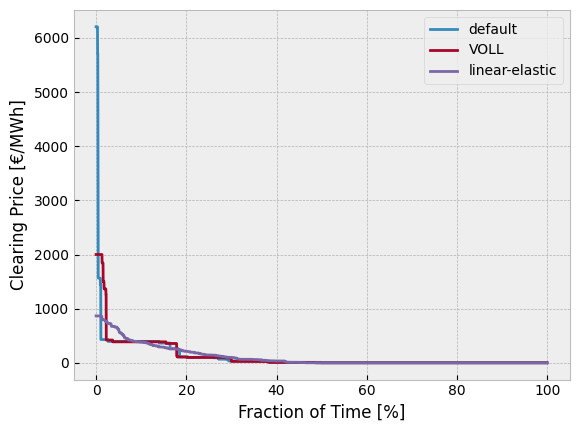

In [15]:
get_price_duration(n).plot(ax=ax, label="linear-elastic", legend=True)
fig

Also, the optimised capacity mix is drastically different. The model cuts down on balancing technologies and rather curtails a lot demand instead. 

In [16]:
capacities["linear-elastic"] = n.statistics.optimal_capacity(round=2)
capacities

inelastic      VOLL  linear-elastic
component   carrier                                              
Link        electrolysis          29.87     28.29           11.37
            turbine              114.70    103.15           21.37
Store       hydrogen storage   43276.43  39706.93         7011.23
StorageUnit battery storage      284.62    273.75          268.46
Generator   solar                465.83    430.89          413.78
            wind                 338.27    369.38          307.46

<Axes: xlabel='snapshot', ylabel='MW'>

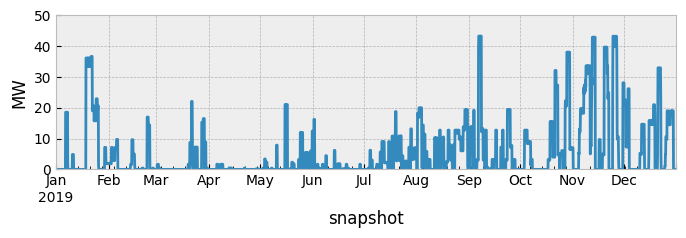

In [17]:
n.generators_t.p["load-shedding"].plot(figsize=(8, 2), ylabel="MW", ylim=(0,50))

The drawback and explanation here is that the linear demand curve becomes unrealistically elastic at higher prices.

## Partial demand elasticity

It is also possible to mix different demand modelling approaches. For instance, keeping 80% of demand perfectly inelastic, while modelling 20% with a linear demand curve.

This just requires adjusting the capacity and cost terms of the load shedding generator (adjusts the slope of the linear demand curve)

In [18]:
n.generators.loc["load-shedding", "p_nom_max"] *= 0.2
n.generators.loc["load-shedding", "marginal_cost_quadratic"] /= 0.2

In [19]:
n.optimize(solver_name="gurobi")

Index(['load-shedding'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 297.84it/s]
INFO:linopy.io: Writing time: 0.28s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


INFO:gurobipy:Set parameter TokenServer to value "ensys3.service.tu-berlin.de"


Read LP format model from file /tmp/linopy-problem-mw61u5t4.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-mw61u5t4.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 64246 rows, 29206 columns, 124144 nonzeros


INFO:gurobipy:obj: 64246 rows, 29206 columns, 124144 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.10")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.10")


INFO:gurobipy:


CPU model: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 64246 rows, 29206 columns and 124144 nonzeros


INFO:gurobipy:Optimize a model with 64246 rows, 29206 columns and 124144 nonzeros


Model fingerprint: 0x0c900259


INFO:gurobipy:Model fingerprint: 0x0c900259


Model has 2920 quadratic objective terms


INFO:gurobipy:Model has 2920 quadratic objective terms


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-04, 3e+00]


INFO:gurobipy:  Matrix range     [2e-04, 3e+00]


  Objective range  [1e+02, 2e+05]


INFO:gurobipy:  Objective range  [1e+02, 2e+05]


  QObjective range [3e+02, 3e+02]


INFO:gurobipy:  QObjective range [3e+02, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+02, 1e+02]


INFO:gurobipy:  RHS range        [1e+02, 1e+02]


Presolve removed 33548 rows and 4342 columns


INFO:gurobipy:Presolve removed 33548 rows and 4342 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 30698 rows, 24864 columns, 86254 nonzeros


INFO:gurobipy:Presolved: 30698 rows, 24864 columns, 86254 nonzeros


Presolved model has 2920 quadratic objective terms


INFO:gurobipy:Presolved model has 2920 quadratic objective terms


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 7.308e+04


INFO:gurobipy: AA' NZ     : 7.308e+04


 Factor NZ  : 4.839e+05 (roughly 26 MB of memory)


INFO:gurobipy: Factor NZ  : 4.839e+05 (roughly 26 MB of memory)


 Factor Ops : 7.913e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 7.913e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.09327361e+11 -8.02815912e+11  1.71e+03 2.93e+02  1.00e+06     0s


INFO:gurobipy:   0   5.09327361e+11 -8.02815912e+11  1.71e+03 2.93e+02  1.00e+06     0s


   1   3.67155184e+10 -4.39119284e+11  4.70e+02 2.42e+02  3.40e+05     0s


INFO:gurobipy:   1   3.67155184e+10 -4.39119284e+11  4.70e+02 2.42e+02  3.40e+05     0s


   2   4.96096910e+09 -2.81636344e+11  2.08e+01 1.21e+01  2.27e+04     0s


INFO:gurobipy:   2   4.96096910e+09 -2.81636344e+11  2.08e+01 1.21e+01  2.27e+04     0s


   3   4.27254561e+09 -1.16973608e+10  1.76e-01 9.56e-02  4.46e+02     0s


INFO:gurobipy:   3   4.27254561e+09 -1.16973608e+10  1.76e-01 9.56e-02  4.46e+02     0s


   4   2.39393968e+09 -2.78393942e+09  3.65e-02 1.52e-02  1.29e+02     0s


INFO:gurobipy:   4   2.39393968e+09 -2.78393942e+09  3.65e-02 1.52e-02  1.29e+02     0s


   5   1.33885820e+09 -9.11626562e+08  9.78e-03 3.58e-03  5.21e+01     0s


INFO:gurobipy:   5   1.33885820e+09 -9.11626562e+08  9.78e-03 3.58e-03  5.21e+01     0s


   6   6.20336365e+08 -2.72965369e+08  2.59e-03 1.45e-03  1.94e+01     0s


INFO:gurobipy:   6   6.20336365e+08 -2.72965369e+08  2.59e-03 1.45e-03  1.94e+01     0s


   7   2.84764784e+08 -7.88260850e+07  8.65e-04 4.89e-04  7.60e+00     0s


INFO:gurobipy:   7   2.84764784e+08 -7.88260850e+07  8.65e-04 4.89e-04  7.60e+00     0s


   8   1.86861975e+08 -1.38530225e+07  3.92e-04 1.75e-04  4.14e+00     0s


INFO:gurobipy:   8   1.86861975e+08 -1.38530225e+07  3.92e-04 1.75e-04  4.14e+00     0s


   9   1.51365973e+08  2.27450928e+07  1.81e-04 4.47e-05  2.64e+00     0s


INFO:gurobipy:   9   1.51365973e+08  2.27450928e+07  1.81e-04 4.47e-05  2.64e+00     0s


  10   1.44701739e+08  3.05098736e+07  1.52e-04 2.67e-05  2.34e+00     0s


INFO:gurobipy:  10   1.44701739e+08  3.05098736e+07  1.52e-04 2.67e-05  2.34e+00     0s


  11   1.41521353e+08  4.96838468e+07  7.77e-05 4.20e-05  1.87e+00     0s


INFO:gurobipy:  11   1.41521353e+08  4.96838468e+07  7.77e-05 4.20e-05  1.87e+00     0s


  12   1.08980416e+08  7.61913562e+07  2.97e-06 5.10e-07  6.47e-01     0s


INFO:gurobipy:  12   1.08980416e+08  7.61913562e+07  2.97e-06 5.10e-07  6.47e-01     0s


  13   1.04531854e+08  8.22474169e+07  1.66e-06 2.85e-07  4.39e-01     0s


INFO:gurobipy:  13   1.04531854e+08  8.22474169e+07  1.66e-06 2.85e-07  4.39e-01     0s


  14   1.02470787e+08  8.56266089e+07  1.12e-06 1.92e-07  3.32e-01     0s


INFO:gurobipy:  14   1.02470787e+08  8.56266089e+07  1.12e-06 1.92e-07  3.32e-01     0s


  15   1.00610491e+08  8.91296699e+07  2.82e-07 4.85e-08  2.26e-01     0s


INFO:gurobipy:  15   1.00610491e+08  8.91296699e+07  2.82e-07 4.85e-08  2.26e-01     0s


  16   9.81652819e+07  9.41568777e+07  3.23e-08 5.55e-09  7.88e-02     0s


INFO:gurobipy:  16   9.81652819e+07  9.41568777e+07  3.23e-08 5.55e-09  7.88e-02     0s


  17   9.80146744e+07  9.46492295e+07  2.74e-08 4.65e-09  6.61e-02     0s


INFO:gurobipy:  17   9.80146744e+07  9.46492295e+07  2.74e-08 4.65e-09  6.61e-02     0s


  18   9.77637860e+07  9.54501267e+07  1.32e-08 2.26e-09  4.55e-02     0s


INFO:gurobipy:  18   9.77637860e+07  9.54501267e+07  1.32e-08 2.26e-09  4.55e-02     0s


  19   9.75144839e+07  9.63459016e+07  1.21e-08 5.24e-10  2.30e-02     0s


INFO:gurobipy:  19   9.75144839e+07  9.63459016e+07  1.21e-08 5.24e-10  2.30e-02     0s


  20   9.73632662e+07  9.69407073e+07  1.62e-09 4.82e-11  8.30e-03     0s


INFO:gurobipy:  20   9.73632662e+07  9.69407073e+07  1.62e-09 4.82e-11  8.30e-03     0s


  21   9.73350357e+07  9.70483310e+07  1.82e-12 1.14e-13  5.63e-03     1s


INFO:gurobipy:  21   9.73350357e+07  9.70483310e+07  1.82e-12 1.14e-13  5.63e-03     1s


  22   9.72931454e+07  9.72407670e+07  1.82e-12 7.11e-14  1.03e-03     1s


INFO:gurobipy:  22   9.72931454e+07  9.72407670e+07  1.82e-12 7.11e-14  1.03e-03     1s


  23   9.72842432e+07  9.72795239e+07  8.55e-11 9.09e-13  9.27e-05     1s


INFO:gurobipy:  23   9.72842432e+07  9.72795239e+07  8.55e-11 9.09e-13  9.27e-05     1s


  24   9.72834258e+07  9.72828577e+07  3.64e-12 1.99e-13  1.12e-05     1s


INFO:gurobipy:  24   9.72834258e+07  9.72828577e+07  3.64e-12 1.99e-13  1.12e-05     1s


  25   9.72833135e+07  9.72832948e+07  3.18e-10 3.98e-13  3.69e-07     1s


INFO:gurobipy:  25   9.72833135e+07  9.72832948e+07  3.18e-10 3.98e-13  3.69e-07     1s


  26   9.72833083e+07  9.72833072e+07  6.17e-10 1.38e-12  2.16e-08     1s


INFO:gurobipy:  26   9.72833083e+07  9.72833072e+07  6.17e-10 1.38e-12  2.16e-08     1s


  27   9.72833078e+07  9.72833077e+07  1.18e-07 1.17e-12  3.22e-09     1s


INFO:gurobipy:  27   9.72833078e+07  9.72833077e+07  1.18e-07 1.17e-12  3.22e-09     1s


INFO:gurobipy:


Barrier solved model in 27 iterations and 0.65 seconds (0.50 work units)


INFO:gurobipy:Barrier solved model in 27 iterations and 0.65 seconds (0.50 work units)


Optimal objective 9.72833078e+07


INFO:gurobipy:Optimal objective 9.72833078e+07


INFO:gurobipy:
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 29206 primals, 64246 duals
Objective: 9.73e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

The price duration curve sees a similar smoothing effect, though not as pronounced.

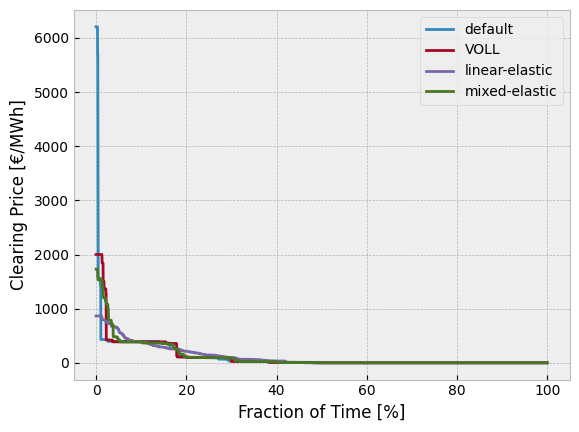

In [20]:
get_price_duration(n).plot(ax=ax, label="mixed-elastic", legend=True)
fig

The optimised capacity mix returns closer to values for the VOLL case, but sees reduced storage and backup capacity as some demand curtailment is seen as economical.

In [21]:
capacities["mixed-elastic"] = n.statistics.optimal_capacity(round=2)
capacities

inelastic      VOLL  linear-elastic  \
component   carrier                                                 
Link        electrolysis          29.87     28.29           11.37   
            turbine              114.70    103.15           21.37   
Store       hydrogen storage   43276.43  39706.93         7011.23   
StorageUnit battery storage      284.62    273.75          268.46   
Generator   solar                465.83    430.89          413.78   
            wind                 338.27    369.38          307.46   

                              mixed-elastic  
component   carrier                          
Link        electrolysis              25.31  
            turbine                   77.79  
Store       hydrogen storage       31002.06  
StorageUnit battery storage          270.78  
Generator   solar                    435.41  
            wind                     352.01

The peak demand reduction is much reduced:

<Axes: xlabel='snapshot', ylabel='MW'>

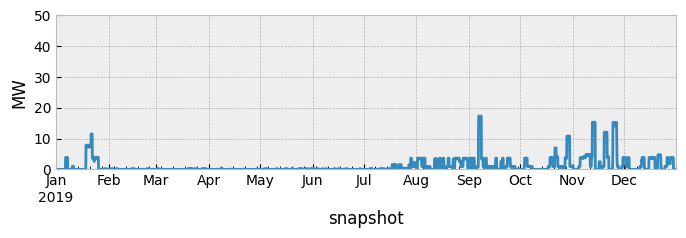

In [22]:
n.generators_t.p["load-shedding"].plot(figsize=(8, 2), ylabel="MW", ylim=(0,50))

## Piecewise-linear demand curve

It is also possible to model a set of piecewise linear demand curves, e.g. to approximate a log-log demand curve ($\ln p = a - b \ln d$), without much modification.

For details see [this paper by Brown, Neumann, Riepin (2024)](https://arxiv.org/abs/2407.21409), Section 3.2 and Appendix A. 